## RSNA Pneumonia Detection Challenge

### Table of Contents
- [Data Import and Exploration](#import)
    - [Files Import](#import_data)
    - [Data Exploration](#data_exploration)
    - [Exploring the target variable](#target_exploration)
    - [Exploring the DICOM file](#dicom_file_exploration)
- [Location of Opacities relating to Pneumonia](#opacities-location)
- [Visualizing No Lung Opacity / Not Normal](#visualizing_opacity)
    - [Visualizing per age groups](#visualizing_age)
- [Exploring Lungs images](#exploring_lungs)
    - [Edge Detection](#edge_detection)
- [Model Fitting](#model_fitting)
    - [Create a train/test split for the model validation](#creating_training_set)
    - [Convert dicom images to PNG](#convert_dicom_to_png)
    - [Fit a CNN](#fitting_cnn)
    - [Visualizing Image Augmentation](#image_augmentation)

<a id='import'></a>
## Data Import and Exploration

In [1]:
## import required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
from pydicom.data import get_testdata_files

%matplotlib inline

In [2]:
ls

Aggregating class labels together.ipynb
CNN implementation.ipynb
Creating Training Set - second approach.ipynb
EDA- on lungs images.ipynb
Final model.ipynb
data_as_arrays/


<a id='import_data'></a>
# Files Import

In [3]:
# Importing the training label file
train_df = pd.read_csv('./datasets/stage_1_train_labels.csv')
train_df.head(20)

patientId      x      y  width  height  Target
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2   00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3   003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6   00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7   006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
10  008c19e8-a820-403a-930a-bc74a4053664    NaN    NaN    NaN     NaN       0
11  009482dc-3db5-48d4-8580-5c89c4f01334    NaN    NaN    NaN     NaN       0
12  009eb222-eabc-4150-8121-d5a6d06b8ebf    NaN    NaN    NaN     NaN       0
13  00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN    NaN    NaN     NaN       0
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1
15  00aecb01-a116-45a2-956c-08d2fa55433f  547.0  299.0  119.0   165.0       1
16  00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  544.0  168.0   244.0       1
17  00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0       1
18  00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b    NaN    NaN    NaN     NaN       0
19  00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  184.0  206.0   506.0       1

In [4]:
## Importing the class labels file
class_info_df = pd.read_csv('./datasets/stage_1_detailed_class_info.csv')
class_info_df.head(10)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

In [5]:
## Check the shape of dataframes
print(train_df.shape)
print(class_info_df.shape)

(28989, 6)
(28989, 2)


In [6]:
## Merging dataframes just to check the values
merged_df = pd.merge(train_df,class_info_df, 
                     left_index = True, 
                     right_index = True)

In [7]:
## check the columns
merged_df.columns

Index(['patientId_x', 'x', 'y', 'width', 'height', 'Target', 'patientId_y',
       'class'],
      dtype='object')

In [8]:
## delete repeated columns
merged_df.drop('patientId_y', axis=1, inplace=True)

In [9]:
## Changing the column names into meaningful names
merged_df.rename(columns={'patientId_x':'patientId', 'Target':'target',
                         'class':'target_class_desc'}, inplace=True)

In [10]:
## Checking the target and corresponding values
merged_df[['target','target_class_desc']].drop_duplicates()

target             target_class_desc
0       0  No Lung Opacity / Not Normal
3       0                        Normal
4       1                  Lung Opacity

###### Note:

1. We have three categories of classes. Among them, two of them belong to cases where there is no Pneumonia (No Lung Opacity/Not Normal and Normal)
2. In the case of Lung Opacity, the reason is Pneumonia

In [11]:
## Group by the target variable
merged_df.groupby(['target','target_class_desc'])[['patientId',]].count()

patientId
target target_class_desc                      
0      No Lung Opacity / Not Normal      11500
       Normal                             8525
1      Lung Opacity                       8964

##### Notes:

1. 11500 patients have some problems in lungs but it is not from pneumonia
2. 8525 patients have healthy lungs
3. 8964 patients have pneumonia in their lungs

<a id='data_exploration'></a>
# Data Exploration

<a id='target_exploration'></a>
## Exploring the target variable

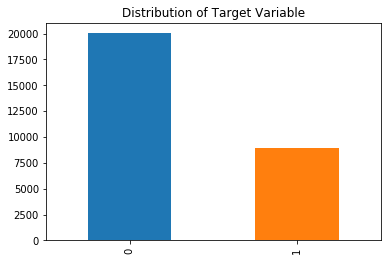

In [12]:
## check the distribution of the Target variable

train_df.Target.value_counts().plot(kind='bar', title = 'Distribution of Target Variable');

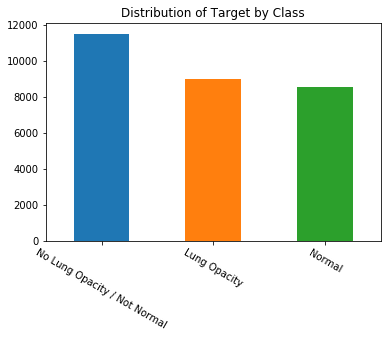

In [13]:
fig,ax = plt.subplots()
merged_df["target_class_desc"].value_counts().plot(kind='bar', 
                                       title = 'Distribution of Target by Class')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-30);

In [14]:
merged_df.head(3)

patientId   x   y  width  height  target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0   

              target_class_desc  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal

In [15]:
## Let's do some analysis on it

merged_df.describe(include='all')

patientId            x            y  \
count                                  28989  8964.000000  8964.000000   
unique                                 25684          NaN          NaN   
top     349f10b4-dc3e-4f3f-b2e4-a5b81448ce87          NaN          NaN   
freq                                       4          NaN          NaN   
mean                                     NaN   391.456158   363.135877   
std                                      NaN   203.945378   148.607149   
min                                      NaN     2.000000     2.000000   
25%                                      NaN   205.000000   246.000000   
50%                                      NaN   320.000000   360.000000   
75%                                      NaN   591.000000   475.000000   
max                                      NaN   817.000000   881.000000   

              width       height        target             target_class_desc  
count   8964.000000  8964.000000  28989.000000                         28989  
unique          NaN          NaN           NaN                             3  
top             NaN          NaN           NaN  No Lung Opacity / Not Normal  
freq            NaN          NaN           NaN                         11500  
mean     220.845382   334.174364      0.309221                           NaN  
std       59.041384   158.097239      0.462180                           NaN  
min       40.000000    45.000000      0.000000                           NaN  
25%      180.000000   207.000000      0.000000                           NaN  
50%      219.000000   304.000000      0.000000                           NaN  
75%      261.000000   445.000000      1.000000                           NaN  
max      528.000000   942.000000      1.000000                           NaN

## Notes:

1. Out of total records of 28989, 25684 patients have unique records. As our earlier analysis, the difference signifies multiple bounding boxes and their values
2. Huge bounding box range for max x=817 to min x=2

<a id='dicom_file_exploration'></a>
## Exploring the DICOM file

### Creating subset of the data for the ease of analysis

In [16]:
merged_df_subset = merged_df.copy()

###### Note: Since, we have a huge dataset, lets work with a sample of images. For the same, I have copied some images in a subset folder and then the script below will extract the information of files inside the folder from the files we imported above. 

In [18]:
## A lot of features for a file name. 
## As such create a new dataframe with all the elements together

def get_patient_metadata():
    dcm_columns = None

    ## for each patient ID, obtain the metadata information from the dicom images
    for n, patient_id in enumerate(merged_df_subset['patientId'].unique()):
    
        # Since, images are named after patiend_Id.dcm, we are extracting it as such
        dcm_file = './datasets/stage_1_train_images_subset/%s.dcm' % patient_id
        
        # Read the dcm file
        try:
            dcm_data = pydicom.read_file(dcm_file)
            
            # Only import columns with meaning values, i.e., drop PixelSpacing and PixelData
            if not dcm_columns:
                # dir will return any DICOM tag names in the dataset that have the specified string 
                # anywhere in the name (case insensitive). Calling dir with no string will list all 
                # tag names available in the dataset
                dcm_columns = dcm_data.dir() # Since, we need all the tag names, we do not pass any arguments
                dcm_columns.remove('PixelSpacing')
                dcm_columns.remove('PixelData')
            
            ## For each column in the dataframe, use patient_ID as index to merge the metadata info
            for col in dcm_columns:
                if not (col in merged_df_subset.columns):
                    merged_df_subset[col] = np.nan # Initially, assign nan values to all the new columns 
                index = merged_df_subset[merged_df_subset['patientId'] == patient_id].index # Extract patientId as index
                merged_df_subset.loc[index, col] = dcm_data.data_element(col).value # Populate the value
            
            del dcm_data
        except:
            pass
    
    #merged_df_subset.head()


In [19]:
## Call this function to obtain data about patients from
## the dicom file
get_patient_metadata()

In [20]:
## Since, the file was too big, we just imported a portion of images.
## So, drop all other image values whose metadata info were not imported
merged_df_subset = merged_df_subset[np.isfinite(merged_df_subset['Columns'])]

In [21]:
merged_df_subset.shape

(64, 40)

In [22]:
merged_df_subset.head()

patientId      x      y  width  height  \
13   00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN    NaN    NaN     NaN   
752  0a03a65b-9e45-4e3d-ae6c-b8a37112ab31    NaN    NaN    NaN     NaN   
753  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27  106.0  685.0  377.0   256.0   
754  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27  582.0  522.0  403.0   444.0   
755  0a09d6e7-5e7c-4100-a690-ad3690fedd3b    NaN    NaN    NaN     NaN   

     target             target_class_desc AccessionNumber  BitsAllocated  \
13        0                        Normal                            8.0   
752       0                        Normal                            8.0   
753       1                  Lung Opacity                            8.0   
754       1                  Lung Opacity                            8.0   
755       0  No Lung Opacity / Not Normal                            8.0   

     BitsStored     ...      SamplesPerPixel  SeriesDescription  \
13          8.0     ...                  1.0           view: PA   
752         8.0     ...                  1.0           view: PA   
753         8.0     ...                  1.0           view: AP   
754         8.0     ...                  1.0           view: AP   
755         8.0     ...                  1.0           view: AP   

                                     SeriesInstanceUID  SeriesNumber  \
13   1.2.276.0.7230010.3.1.3.8323329.18264.15178744...           1.0   
752  1.2.276.0.7230010.3.1.3.8323329.8154.151787433...           1.0   
753  1.2.276.0.7230010.3.1.3.8323329.26390.15178744...           1.0   
754  1.2.276.0.7230010.3.1.3.8323329.26390.15178744...           1.0   
755  1.2.276.0.7230010.3.1.3.8323329.8736.151787433...           1.0   

     SpecificCharacterSet StudyDate StudyID  \
13             ISO_IR 100  19010101           
752            ISO_IR 100  19010101           
753            ISO_IR 100  19010101           
754            ISO_IR 100  19010101           
755            ISO_IR 100  19010101           

                                      StudyInstanceUID  StudyTime ViewPosition  
13   1.2.276.0.7230010.3.1.2.8323329.18264.15178744...  000000.00           PA  
752  1.2.276.0.7230010.3.1.2.8323329.8154.151787433...  000000.00           PA  
753  1.2.276.0.7230010.3.1.2.8323329.26390.15178744...  000000.00           AP  
754  1.2.276.0.7230010.3.1.2.8323329.26390.15178744...  000000.00           AP  
755  1.2.276.0.7230010.3.1.2.8323329.8736.151787433...  000000.00           AP  

[5 rows x 40 columns]

In [23]:
# reset index
merged_df_subset.reset_index(inplace = True)

In [24]:
merged_df_subset.drop('index', axis=1, inplace=True)

In [25]:
merged_df_subset.head(2).T

0  \
patientId                                 00a85be6-6eb0-421d-8acf-ff2dc0007e8a   
x                                                                          NaN   
y                                                                          NaN   
width                                                                      NaN   
height                                                                     NaN   
target                                                                       0   
target_class_desc                                                       Normal   
AccessionNumber                                                                  
BitsAllocated                                                                8   
BitsStored                                                                   8   
BodyPartExamined                                                         CHEST   
Columns                                                                   1024   
ConversionType                                                             WSD   
HighBit                                                                      7   
InstanceNumber                                                               1   
LossyImageCompression                                                       01   
LossyImageCompressionMethod                                        ISO_10918_1   
Modality                                                                    CR   
PatientAge                                                                  48   
PatientBirthDate                                                                 
PatientID                                 00a85be6-6eb0-421d-8acf-ff2dc0007e8a   
PatientName                               00a85be6-6eb0-421d-8acf-ff2dc0007e8a   
PatientOrientation                                                               
PatientSex                                                                   M   
PhotometricInterpretation                                          MONOCHROME2   
PixelRepresentation                                                          0   
ReferringPhysicianName                                                           
Rows                                                                      1024   
SOPClassUID                                          1.2.840.10008.5.1.4.1.1.7   
SOPInstanceUID               1.2.276.0.7230010.3.1.4.8323329.18264.15178744...   
SamplesPerPixel                                                              1   
SeriesDescription                                                     view: PA   
SeriesInstanceUID            1.2.276.0.7230010.3.1.3.8323329.18264.15178744...   
SeriesNumber                                                                 1   
SpecificCharacterSet                                                ISO_IR 100   
StudyDate                                                             19010101   
StudyID                                                                          
StudyInstanceUID             1.2.276.0.7230010.3.1.2.8323329.18264.15178744...   
StudyTime                                                            000000.00   
ViewPosition                                                                PA   

                                                                             1  
patientId                                 0a03a65b-9e45-4e3d-ae6c-b8a37112ab31  
x                                                                          NaN  
y                                                                          NaN  
width                                                                      NaN  
height                                                                     NaN  
target                                                                       0  
target_class_desc                                                       Normal  
AccessionNumber                                                   

###### Notes: Each image dimension is 1024 x 1024

In [26]:
# change the columns to proper names 
merged_df_subset.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'target', 'target_class_desc',
       'AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined',
       'Columns', 'ConversionType', 'HighBit', 'InstanceNumber',
       'LossyImageCompression', 'LossyImageCompressionMethod', 'Modality',
       'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientName',
       'PatientOrientation', 'PatientSex', 'PhotometricInterpretation',
       'PixelRepresentation', 'ReferringPhysicianName', 'Rows', 'SOPClassUID',
       'SOPInstanceUID', 'SamplesPerPixel', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesNumber', 'SpecificCharacterSet',
       'StudyDate', 'StudyID', 'StudyInstanceUID', 'StudyTime',
       'ViewPosition'],
      dtype='object')

In [27]:
merged_df_subset.rename(columns={
    'AccessionNumber'             : 'accession_num',
    'BitsAllocated'               : 'bits_allocated',
    'BitsStored'                  : 'bits_stored',
    'BodyPartExamined'            : 'body_part',
    'Columns'                     : 'columns', 
    'ConversionType'              : 'conversion_type',
    'HighBit'                     : 'high_bit',
    'InstanceNumber'              : 'instance_num',
    'LossyImageCompression'       : 'lossy_image_compres_val',
    'LossyImageCompressionMethod' : 'lossy_image_compres_method', 
    'Modality'                    : 'method',
    'PatientAge'                  : 'patient_age',  
    'PatientBirthDate'            : 'patient_birthdate', 
    'PatientOrientation'          : 'patient_orientation',
    'PatientSex'                  : 'patient_sex', 
    'PhotometricInterpretation'   : 'photometric_interpretation',
    'PixelRepresentation'         : 'pixel_representation', 
    'ReferringPhysicianName'      : 'physician_name', 
    'Rows'                        : 'rows', 
    'SOPClassUID'                 : 'sop_class_uid',
    'SOPInstanceUID'              : 'sop_instance_uid', 
    'SamplesPerPixel'             : 'samples_per_pixel',
    'SeriesDescription'           : 'series_description',
    'SeriesInstanceUID'           : 'series_instance_uid', 
    'SeriesNumber'                : 'series_number', 
    'SpecificCharacterSet'        : 'specific_character_set',
    'StudyDate'                   : 'study_date', 
    'StudyID'                     : 'study_ID', 
    'StudyInstanceUID'            : 'study_instance_UID', 
    'StudyTime'                   : 'study_time',
    'ViewPosition'                : 'view_position'
}, inplace=True)

In [28]:
merged_df_subset.head(2).T

0  \
patientId                                00a85be6-6eb0-421d-8acf-ff2dc0007e8a   
x                                                                         NaN   
y                                                                         NaN   
width                                                                     NaN   
height                                                                    NaN   
target                                                                      0   
target_class_desc                                                      Normal   
accession_num                                                                   
bits_allocated                                                              8   
bits_stored                                                                 8   
body_part                                                               CHEST   
columns                                                                  1024   
conversion_type                                                           WSD   
high_bit                                                                    7   
instance_num                                                                1   
lossy_image_compres_val                                                    01   
lossy_image_compres_method                                        ISO_10918_1   
method                                                                     CR   
patient_age                                                                48   
patient_birthdate                                                               
PatientID                                00a85be6-6eb0-421d-8acf-ff2dc0007e8a   
PatientName                              00a85be6-6eb0-421d-8acf-ff2dc0007e8a   
patient_orientation                                                             
patient_sex                                                                 M   
photometric_interpretation                                        MONOCHROME2   
pixel_representation                                                        0   
physician_name                                                                  
rows                                                                     1024   
sop_class_uid                                       1.2.840.10008.5.1.4.1.1.7   
sop_instance_uid            1.2.276.0.7230010.3.1.4.8323329.18264.15178744...   
samples_per_pixel                                                           1   
series_description                                                   view: PA   
series_instance_uid         1.2.276.0.7230010.3.1.3.8323329.18264.15178744...   
series_number                                                               1   
specific_character_set                                             ISO_IR 100   
study_date                                                           19010101   
study_ID                                                                        
study_instance_UID          1.2.276.0.7230010.3.1.2.8323329.18264.15178744...   
study_time                                                          000000.00   
view_position                                                              PA   

                                                                            1  
patientId                                0a03a65b-9e45-4e3d-ae6c-b8a37112ab31  
x                                                                         NaN  
y                                                                         NaN  
width                                                                     NaN  
height                                                                    NaN  
target                                                                      0  
target_class_desc                                                      Normal  
accession_num                                                                  
bits_allocated                    

In [29]:
## load some images of different target classes
merged_df_subset.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'target', 'target_class_desc',
       'accession_num', 'bits_allocated', 'bits_stored', 'body_part',
       'columns', 'conversion_type', 'high_bit', 'instance_num',
       'lossy_image_compres_val', 'lossy_image_compres_method', 'method',
       'patient_age', 'patient_birthdate', 'PatientID', 'PatientName',
       'patient_orientation', 'patient_sex', 'photometric_interpretation',
       'pixel_representation', 'physician_name', 'rows', 'sop_class_uid',
       'sop_instance_uid', 'samples_per_pixel', 'series_description',
       'series_instance_uid', 'series_number', 'specific_character_set',
       'study_date', 'study_ID', 'study_instance_UID', 'study_time',
       'view_position'],
      dtype='object')

In [30]:
# Lets load some normal lungs images
merged_df_subset[merged_df_subset['target_class_desc'] == 'Normal'][
    ['patientId','target_class_desc']].head()

patientId target_class_desc
0   00a85be6-6eb0-421d-8acf-ff2dc0007e8a            Normal
1   0a03a65b-9e45-4e3d-ae6c-b8a37112ab31            Normal
7   0a120828-703c-4273-9d62-317dc92c560e            Normal
11  0a22297d-22e1-4f3f-aa10-edcd220c1cb0            Normal
14  0a29f841-b738-499a-bc8e-0589de77ef82            Normal

In [31]:
normal_lungs = list(merged_df_subset[merged_df_subset['target_class_desc'] == 'Normal']
                    ['patientId'])

In [32]:
normal_lungs

['00a85be6-6eb0-421d-8acf-ff2dc0007e8a',
 '0a03a65b-9e45-4e3d-ae6c-b8a37112ab31',
 '0a120828-703c-4273-9d62-317dc92c560e',
 '0a22297d-22e1-4f3f-aa10-edcd220c1cb0',
 '0a29f841-b738-499a-bc8e-0589de77ef82',
 '0a3227d3-c8df-44fc-b1cb-fb0eb743f79f',
 '0a34d5d9-8c50-4b97-9c9c-e5d6ed862a3d',
 '0a41d5c4-83b0-43e4-b98f-be69dcdd4636',
 '0a461c5f-08e6-4c86-9ecd-5246e613f8c2',
 '0a48e8eb-2c55-46ac-82b0-9bea6c5b7872',
 '0a4d9634-7ee8-4512-ba83-6ff5e352b2c2',
 '0a50d5b7-436c-464e-aba4-4264cebb35be',
 '0a55219b-5303-4490-b173-6039f355db2f',
 '0a5c4dcb-33ac-4466-9dbf-42ed5c8ec1f0',
 '0a63a331-3e17-4e23-8a9f-f7a4ec850a1b',
 '0a74badc-f221-4017-96a6-055ee057b57d',
 '0a7b13a9-bcfe-4a99-b699-4c8cf6882f04',
 '0a828af6-b7c6-4757-88e4-dea54fe6cdc9',
 '0a8db596-9ef7-4b6c-a5db-7bb6029d0b9d']

In [33]:
len(normal_lungs)

19

In [34]:
train_images_dir = './datasets/stage_1_train_images_subset/'

In [35]:
ds = pydicom.dcmread(train_images_dir + '00a85be6-6eb0-421d-8acf-ff2dc0007e8a' + '.dcm')

In [36]:
print(ds)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.18264.1517874409.541909
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '00a85be6-6eb0-421d-8acf-ff2dc0007e8a'
(0010, 0020) Patient ID                          LO: '00a85be6-6eb0-421d-8acf-ff2dc0007e8a'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

In [37]:
ds.pixel_array.shape

(1024, 1024)

In [38]:
test_image = ds

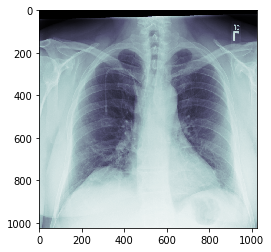

In [39]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

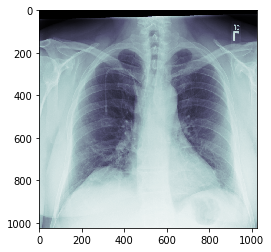

In [45]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone);

In [40]:
merged_df_subset.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'target', 'target_class_desc',
       'accession_num', 'bits_allocated', 'bits_stored', 'body_part',
       'columns', 'conversion_type', 'high_bit', 'instance_num',
       'lossy_image_compres_val', 'lossy_image_compres_method', 'method',
       'patient_age', 'patient_birthdate', 'PatientID', 'PatientName',
       'patient_orientation', 'patient_sex', 'photometric_interpretation',
       'pixel_representation', 'physician_name', 'rows', 'sop_class_uid',
       'sop_instance_uid', 'samples_per_pixel', 'series_description',
       'series_instance_uid', 'series_number', 'specific_character_set',
       'study_date', 'study_ID', 'study_instance_UID', 'study_time',
       'view_position'],
      dtype='object')

Text(0.5,0,'Age')

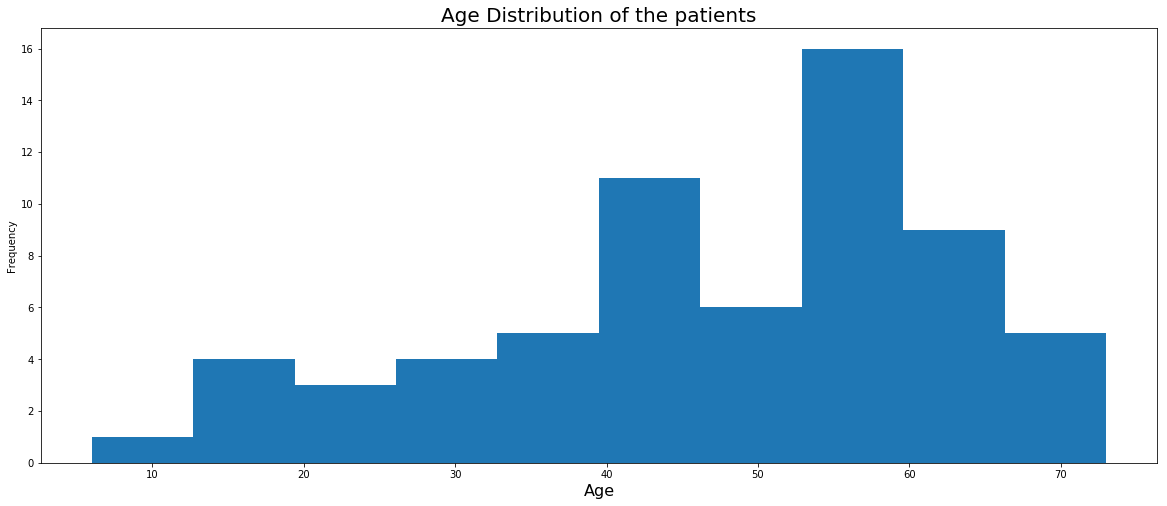

In [45]:
## Plot the age distribution of patients in the subset folder
merged_df_subset.patient_age = merged_df_subset.patient_age.astype(float)
ax = merged_df_subset.patient_age.plot(kind = 'hist', figsize = (20,8))
ax.set_title('Age Distribution of the patients', fontdict={'fontsize': 20});
ax.set_xlabel('Age', fontdict={'fontsize': 16})

##### Note:

Age distribution of patients are evenly distributed accross different age groups and as such the data is skewed to the left.

<a id='opacities-location'></a>
## Location of Opacities relating to Pneumonia

In [46]:
train_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

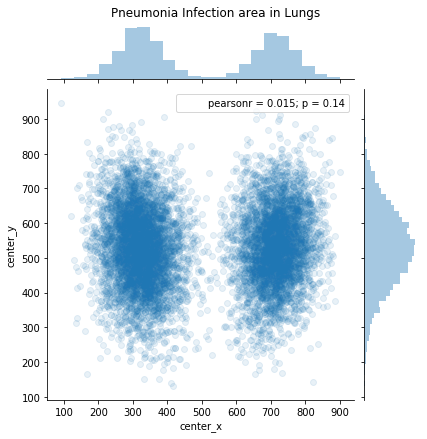

In [47]:
centers = (train_df.dropna(subset=['x'])
           .assign(center_x=train_df.x + train_df.width / 2, 
                   center_y=train_df.y + train_df.height / 2))

ax = sns.jointplot("center_x", "center_y", data=centers, alpha=0.1)
_ = ax.fig.suptitle("Pneumonia Infection area in Lungs", y=1.01)

##### Note: Density of Lung opacities 

In the above diagram, we can see two lungs side and we can see that pneumonia is distributed over the centre area of the images

<a id='visualizing_opacity'></a>
## Visualizing No Lung Opacity / Not Normal

###### Choosing the subset images

In [49]:
filepath = './datasets/stage_1_train_images_subset/'

In [50]:
## Obtain the filename in the image subset folder
import os

filename_list = []
def get_files(filepath):  
    for file in os.listdir(filepath):
        if os.path.isfile(os.path.join(filepath, file)):
            yield file

for file in get_files(filepath):  
    filename_list.append(file[:-4])

In [51]:
filename_list

['0a19fb3c-36ef-401b-9deb-77f4f86d5d80',
 '0a23debc-fa30-486f-9555-750be017ae75',
 '0a6a5956-58cf-4f17-9e39-7e0d17310f67',
 '0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27',
 '0a03a65b-9e45-4e3d-ae6c-b8a37112ab31',
 '0a25c372-266b-4d06-9ff5-a4fbb0461be4',
 '0a8efdc1-1dff-4d65-8948-c56a5d74a906',
 '0a55219b-5303-4490-b173-6039f355db2f',
 '0a09d6e7-5e7c-4100-a690-ad3690fedd3b',
 '0a7b0cc8-af04-4d2c-9267-6fdfb05f48f2',
 '00a85be6-6eb0-421d-8acf-ff2dc0007e8a',
 '0a50d5b7-436c-464e-aba4-4264cebb35be',
 '0a97ffca-0d28-47ff-92ea-bf7144a91b66',
 '0a0f6755-610d-4b7c-a460-5f5a8f5c0743',
 '0a5c4dcb-33ac-4466-9dbf-42ed5c8ec1f0',
 '0a62df77-7459-4acc-9cca-a62c2cec4b0f',
 '0a7b13a9-bcfe-4a99-b699-4c8cf6882f04',
 '0a9fd225-a33a-47de-849e-156933b21296',
 '0a2c130c-c536-4651-836d-95d07e9a89cf',
 '0a4b4307-d370-416e-afe5-7c9aeb1d6953',
 '0a3227d3-c8df-44fc-b1cb-fb0eb743f79f',
 '0a15acdd-248c-47ff-abfc-d33f8a0cf417',
 '0a66f58c-f98d-41d1-89af-4e0136888e13',
 '0a828af6-b7c6-4757-88e4-dea54fe6cdc9',
 '0a8b9570-2684-

In [52]:
merged_df_subset = merged_df_subset.iloc[0:0]

In [53]:
merged_df_subset = merged_df.copy()

In [54]:
merged_df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'target',
       'target_class_desc'],
      dtype='object')

In [55]:
merged_df.head()

patientId      x      y  width  height  target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

              target_class_desc  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [56]:
## Extract only the information about the patient with filenames in the folder
merged_df_subset = merged_df[merged_df['patientId'].isin(filename_list)]

In [57]:
merged_df_subset.head()

patientId      x      y  width  height  \
13   00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN    NaN    NaN     NaN   
752  0a03a65b-9e45-4e3d-ae6c-b8a37112ab31    NaN    NaN    NaN     NaN   
753  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27  106.0  685.0  377.0   256.0   
754  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27  582.0  522.0  403.0   444.0   
755  0a09d6e7-5e7c-4100-a690-ad3690fedd3b    NaN    NaN    NaN     NaN   

     target             target_class_desc  
13        0                        Normal  
752       0                        Normal  
753       1                  Lung Opacity  
754       1                  Lung Opacity  
755       0  No Lung Opacity / Not Normal

In [58]:
merged_df_subset.shape

(64, 7)

In [59]:
## Extract information on patient sex and patient age
patient_sex = []
patient_age = []
for patientId in filename_list:
    dcm_file = filepath + '%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    patient_sex.append(dcm_data.PatientSex)
    patient_age.append(int(dcm_data.PatientAge))

In [60]:
patient_info = pd.DataFrame({'patientId': filename_list, 'patientSex': patient_sex, 
                             'patientAge': patient_age})

In [61]:
patient_info.head()

patientAge                             patientId patientSex
0          57  0a19fb3c-36ef-401b-9deb-77f4f86d5d80          F
1          47  0a23debc-fa30-486f-9555-750be017ae75          M
2          33  0a6a5956-58cf-4f17-9e39-7e0d17310f67          F
3          53  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27          M
4          53  0a03a65b-9e45-4e3d-ae6c-b8a37112ab31          F

In [62]:
merged_df_subset.head()

patientId      x      y  width  height  \
13   00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN    NaN    NaN     NaN   
752  0a03a65b-9e45-4e3d-ae6c-b8a37112ab31    NaN    NaN    NaN     NaN   
753  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27  106.0  685.0  377.0   256.0   
754  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27  582.0  522.0  403.0   444.0   
755  0a09d6e7-5e7c-4100-a690-ad3690fedd3b    NaN    NaN    NaN     NaN   

     target             target_class_desc  
13        0                        Normal  
752       0                        Normal  
753       1                  Lung Opacity  
754       1                  Lung Opacity  
755       0  No Lung Opacity / Not Normal

In [63]:
patient_info.head()

patientAge                             patientId patientSex
0          57  0a19fb3c-36ef-401b-9deb-77f4f86d5d80          F
1          47  0a23debc-fa30-486f-9555-750be017ae75          M
2          33  0a6a5956-58cf-4f17-9e39-7e0d17310f67          F
3          53  0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27          M
4          53  0a03a65b-9e45-4e3d-ae6c-b8a37112ab31          F

<a id='visualizing_gender'></a>
### Visualizing Gender distribution among patients

In [65]:
## Function to draw image
def draw_img(patient_id, title=None):
    dcm_file = filepath + '%s.dcm' % patient_id
    dcm_data = pydicom.read_file(dcm_file)
    plt.imshow(dcm_data.pixel_array)
    if title is not None:
        plt.title(title)

In [66]:
## PLot the images in grids
def draw_grid(arr_patients, rows=5, columns=4, titles=None, figsize=(15, 15)):
    fig=plt.figure(figsize=figsize)
    for i in range(1, columns*rows + 1):
        if(i <= len(arr_patients)):
            fig.add_subplot(rows, columns, i)
            if titles is None:
                    draw_img(arr_patients[i - 1])
            else:
                    draw_img(arr_patients[i - 1], title=titles[i - 1])
    plt.show()

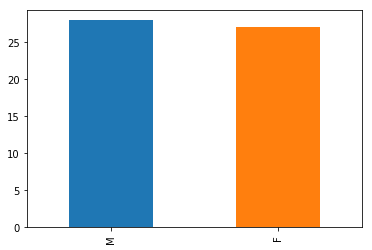

In [73]:
## Plot patientSex distribution
patient_info['patientSex'].value_counts().plot.bar()

###### Note: The sameple contains almost equal distribution of male and female patients

<a id='visualizing_age'></a>
### Visualizing per age groups

In [74]:
## Divide the patients into different age groups
patients_greater_50 = patient_info[patient_info['patientAge']>=50]

patients_less_5 = patient_info[patient_info['patientAge']<5]

patient_adults = patient_info[(patient_info['patientAge']>=5) & 
                              (patient_info['patientAge']< 30)]

patients_mid_age = patient_info[(patient_info['patientAge']>=30) & 
                                (patient_info['patientAge']< 50)]

In [75]:
## Check values for infants
patients_less_5

Empty DataFrame
Columns: [patientAge, patientId, patientSex]
Index: []

###### Notes: We do not have patients with age less than 5 in our subset

In [76]:
draw_grid(patients_less_5['patientId'].tolist())

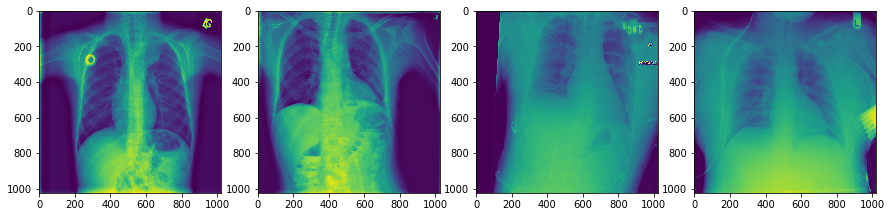

In [77]:
## Check the adults lungs
draw_grid(patient_adults['patientId'].tolist(),1,4)

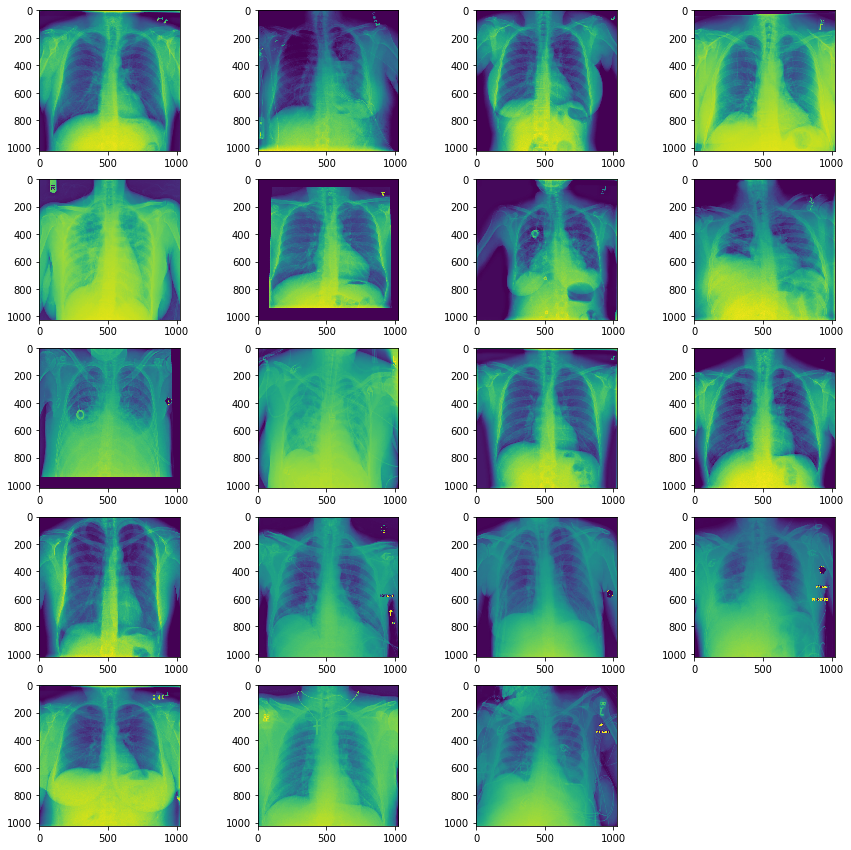

In [78]:
## Check the lungs of people with age > 30 and <50
draw_grid(patients_mid_age['patientId'].tolist())

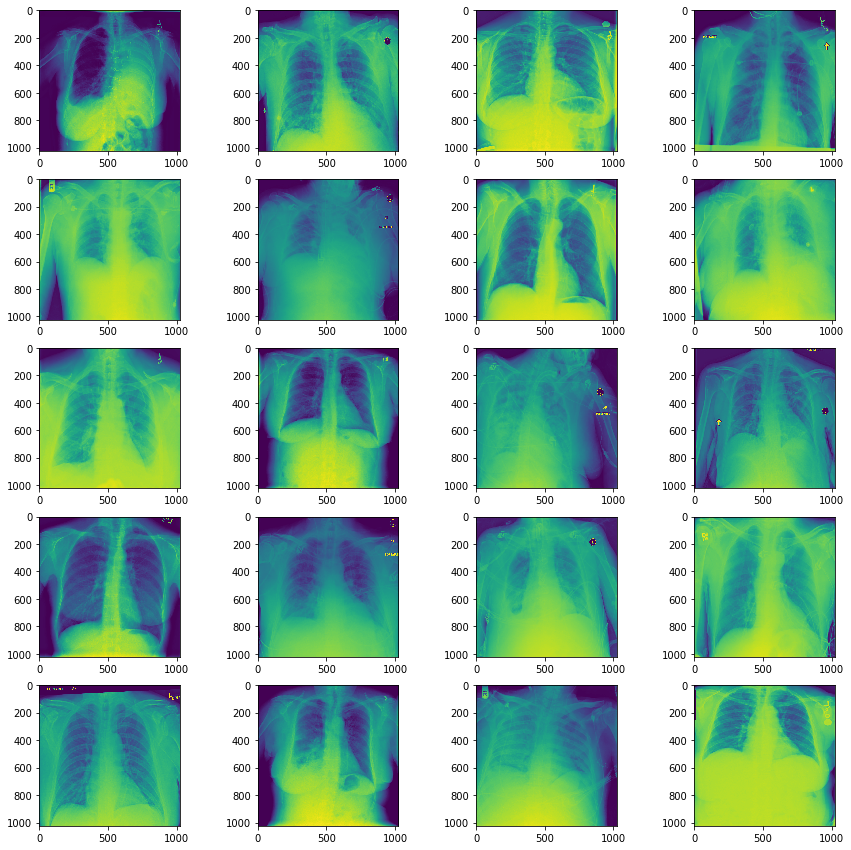

In [79]:
## print sample images of lungs of people greater than 50 years
draw_grid(patients_greater_50['patientId'].tolist())

<a id='exploring_lungs'></a>
## Exploring Lungs images

In [85]:
# simple features that can be easily extracted and used for training deep networks
# these features may be used along with original image

plt.figure(figsize=(30,15))
# plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0)  #adjust this to change vertical and horiz. spacings..
nImg = 3  #no. of images to process
j = -1
df = merged_df_subset[merged_df_subset['target_class_desc']==
                      'No Lung Opacity / Not Normal']
df = df.reset_index()
df

index                             patientId   x   y  width  height  \
0     755  0a09d6e7-5e7c-4100-a690-ad3690fedd3b NaN NaN    NaN     NaN   
1     756  0a0f6755-610d-4b7c-a460-5f5a8f5c0743 NaN NaN    NaN     NaN   
2     761  0a19fb3c-36ef-401b-9deb-77f4f86d5d80 NaN NaN    NaN     NaN   
3     763  0a23debc-fa30-486f-9555-750be017ae75 NaN NaN    NaN     NaN   
4     764  0a25c372-266b-4d06-9ff5-a4fbb0461be4 NaN NaN    NaN     NaN   
5     770  0a35c2fa-9f9e-4157-8deb-8e5d9e69dbc3 NaN NaN    NaN     NaN   
6     777  0a4b4307-d370-416e-afe5-7c9aeb1d6953 NaN NaN    NaN     NaN   
7     783  0a5a6574-d94d-441f-afe4-115ba66b322e NaN NaN    NaN     NaN   
8     784  0a5b4860-e6ab-4737-a389-9d0cf7300770 NaN NaN    NaN     NaN   
9     794  0a72a6fe-0dde-49f0-bb65-d3d73366b83f NaN NaN    NaN     NaN   
10    796  0a74f788-cd7e-47a5-a437-cb9a7dd00a06 NaN NaN    NaN     NaN   
11    797  0a796f83-f908-4b83-9252-e513d107be2e NaN NaN    NaN     NaN   
12    798  0a7b0cc8-af04-4d2c-9267-6fdfb05f48f2 NaN NaN    NaN     NaN   
13    800  0a80033c-8a64-4810-9ecb-6013f7b0dde9 NaN NaN    NaN     NaN   
14    804  0a842feb-40ac-44aa-bcf6-d37109e59006 NaN NaN    NaN     NaN   
15    806  0a8b9570-2684-48e1-b016-e14a6a79cd3e NaN NaN    NaN     NaN   
16    807  0a8ccb49-debc-4e9a-b5dc-eefc3fe909ca NaN NaN    NaN     NaN   
17    812  0a97ffca-0d28-47ff-92ea-bf7144a91b66 NaN NaN    NaN     NaN   

    target             target_class_desc  
0        0  No Lung Opacity / Not Normal  
1        0  No Lung Opacity / Not Normal  
2        0  No Lung Opacity / Not Normal  
3        0  No Lung Opacity / Not Normal  
4        0  No Lung Opacity / Not Normal  
5        0  No Lung Opacity / Not Normal  
6        0  No Lung Opacity / Not Normal  
7        0  No Lung Opacity / Not Normal  
8        0  No Lung Opacity / Not Normal  
9        0  No Lung Opacity / Not Normal  
10       0  No Lung Opacity / Not Normal  
11       0  No Lung Opacity / Not Normal  
12       0  No Lung Opacity / Not Normal  
13       0  No Lung Opacity / Not Normal  
14       0  No Lung Opacity / Not Normal  
15       0  No Lung Opacity / Not Normal  
16       0  No Lung Opacity / Not Normal  
17       0  No Lung Opacity / Not Normal

<a id='edge_detection'></a>
### Edge Detection

In [100]:
## for edge detection
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import feature

In [101]:
## Edge-based segmentation using Canny

def get_filtered_edges(image_file):
    
    # Generate noisy image of a square
    im = image_file
    
    #im = ndi.rotate(im, 15, mode='constant')
    #im = ndi.gaussian_filter(im, 4)
    #im += 0.2 * np.random.random(im.shape)
    
    # Compute the Canny filter for two values of sigma
    edges1 = feature.canny(im,)
    edges2 = feature.canny(im, sigma=0.1)
    edges3 = feature.canny(im, sigma=0.01)
    edges4 = feature.canny(im, sigma=0.001)
    edges5 = feature.canny(im, sigma=0.0001)
   
    
    # display results
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, 
                                                       figsize=(18, 5),sharex=True, 
                                                       sharey=True)
    
    ax1.imshow(im, cmap=plt.cm.gray)
    #ax1.axis('off')
    ax1.set_title('noisy image', fontsize=10)
    
    ax2.imshow(edges1, cmap=plt.cm.gray)
    #ax2.axis('off')
    ax2.set_title('Canny filter, $\sigma=1$', fontsize=10)
    
    ax3.imshow(edges2, cmap=plt.cm.gray)
    #ax3.axis('off')
    ax3.set_title('Canny filter, $\sigma=0.1$', fontsize=10)
    
    ax4.imshow(edges3, cmap=plt.cm.gray)
    #ax4.axis('off')
    ax4.set_title('Canny filter, $\sigma=0.01$', fontsize=10)
    
    ax5.imshow(edges4, cmap=plt.cm.gray)
    #ax5.axis('off')
    ax5.set_title('Canny filter, $\sigma=0.001$', fontsize=10)
    
    ax6.imshow(edges5, cmap=plt.cm.gray)
    #ax6.axis('off')
    ax6.set_title('Canny filter, $\sigma=0.0001$', fontsize=10)
    
    fig.tight_layout()
    
    plt.show()

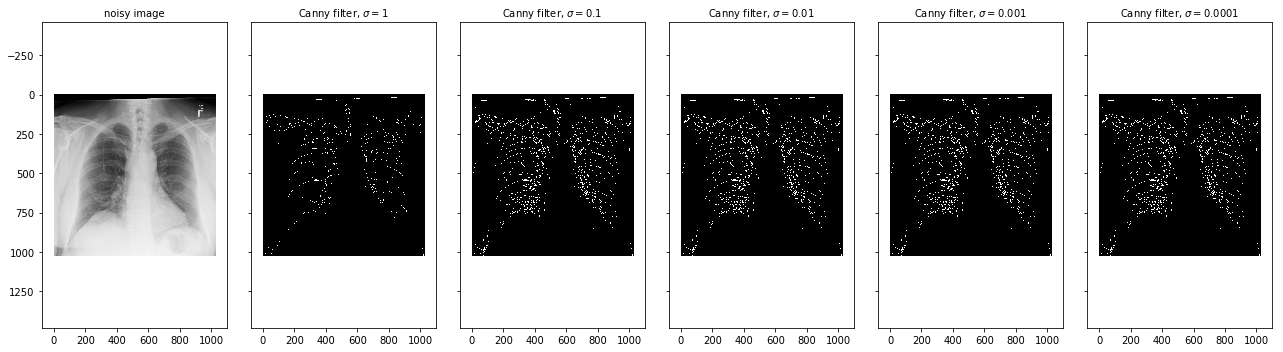

In [102]:
# Healthy lungs image
get_filtered_edges(ds.pixel_array)

In [103]:
# Pneumonia infected lungs
ds = pydicom.dcmread(train_images_dir + '0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27' + '.dcm')

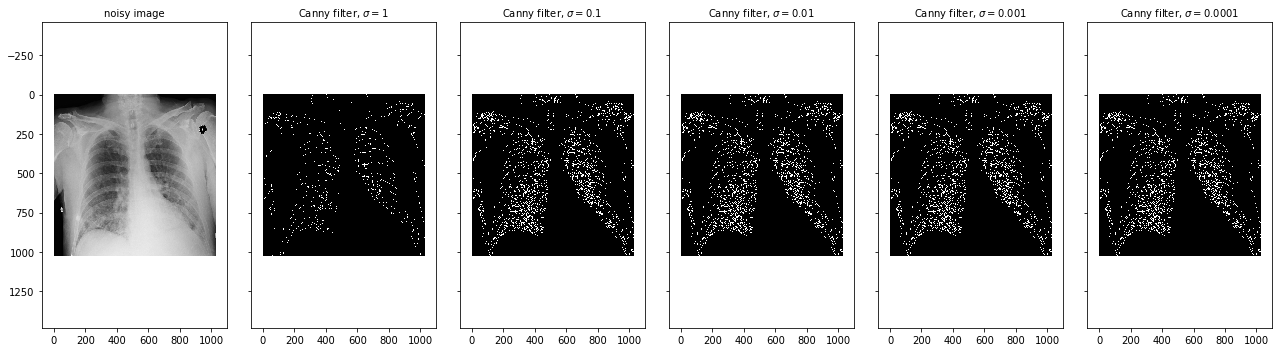

In [104]:
get_filtered_edges(ds.pixel_array)

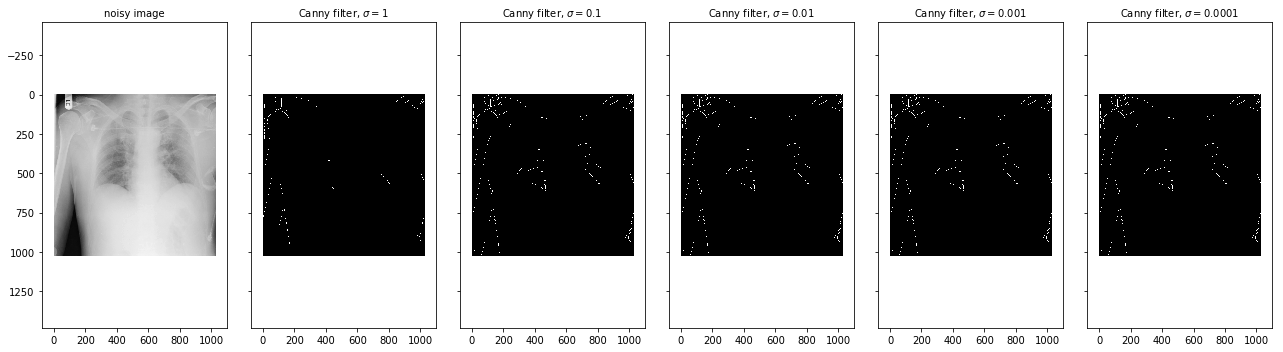

In [105]:
## Non-normal lungs
ds = pydicom.dcmread(train_images_dir + '0a09d6e7-5e7c-4100-a690-ad3690fedd3b' + '.dcm')
get_filtered_edges(ds.pixel_array)

In [106]:
normal_patient_ids = merged_df_subset[['patientId']][merged_df_subset['target_class_desc'] == 'Normal']

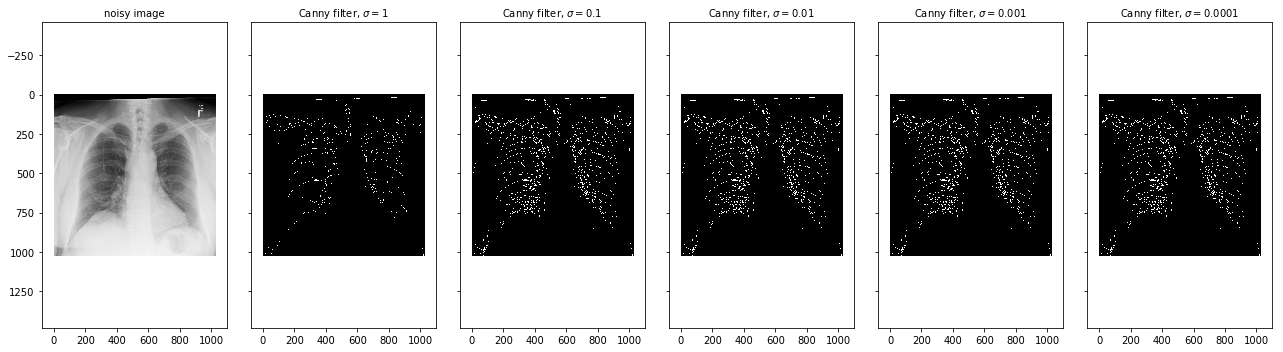

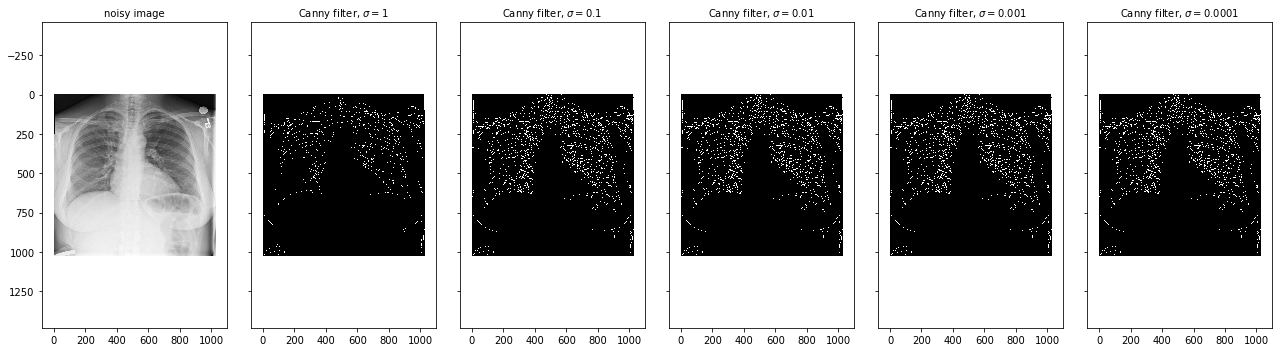

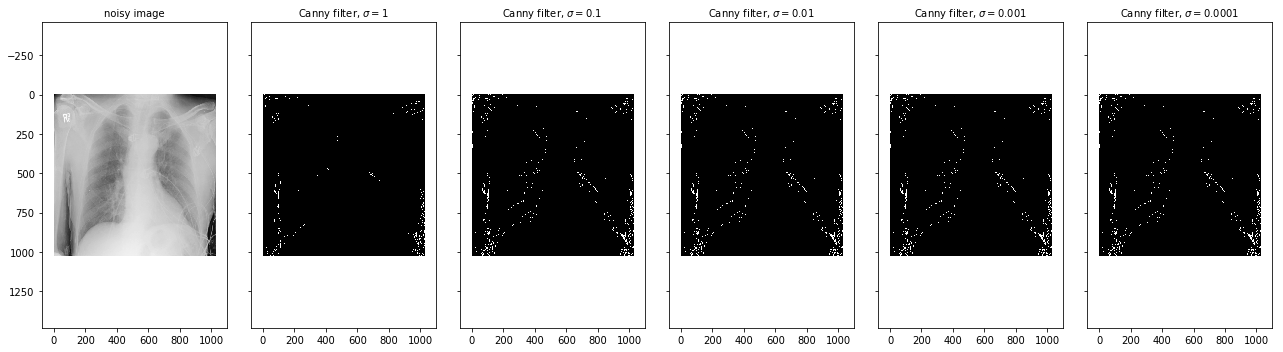

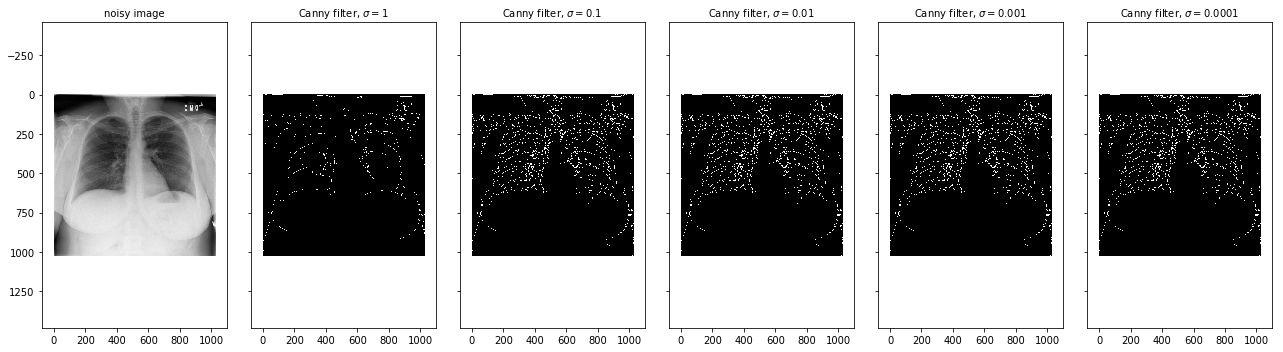

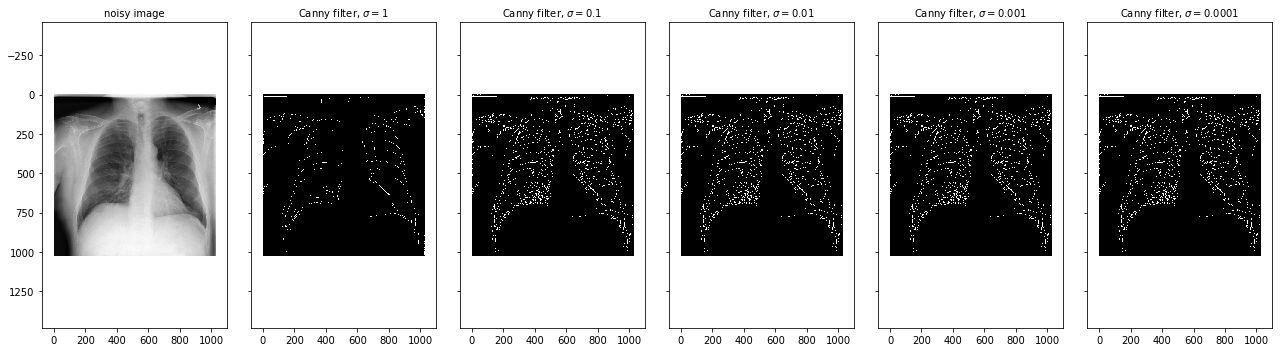

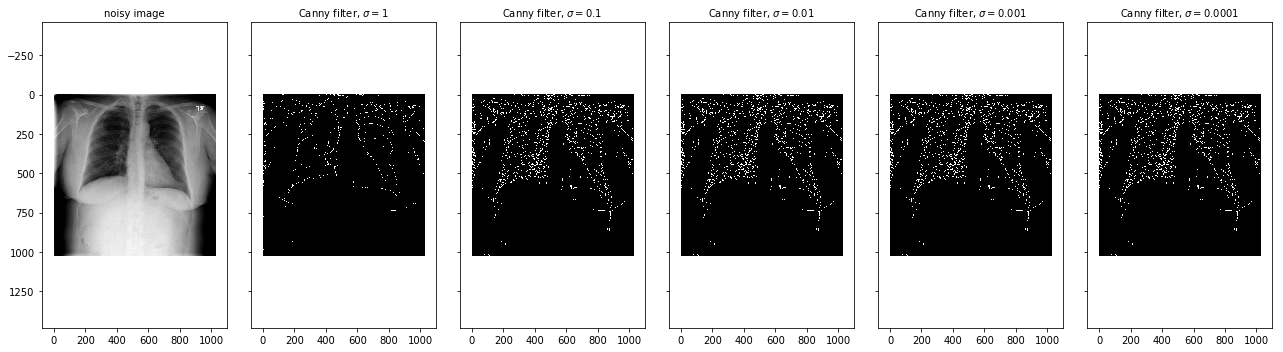

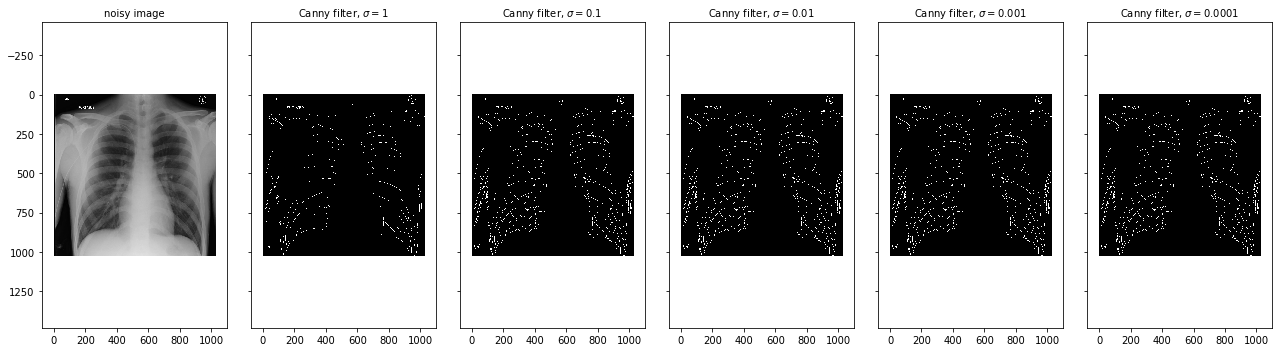

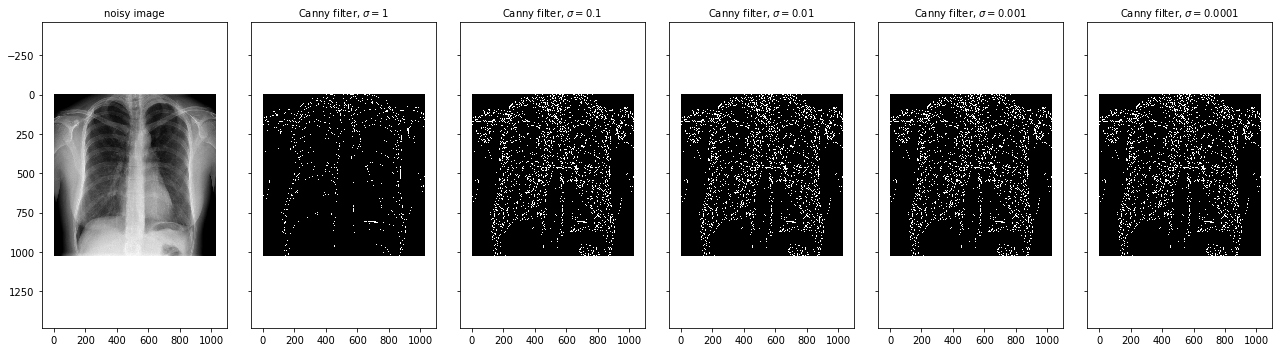

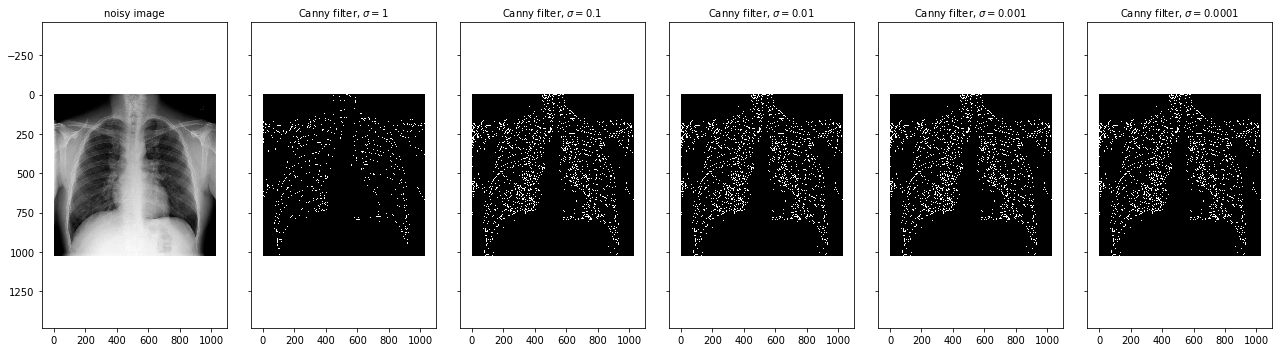

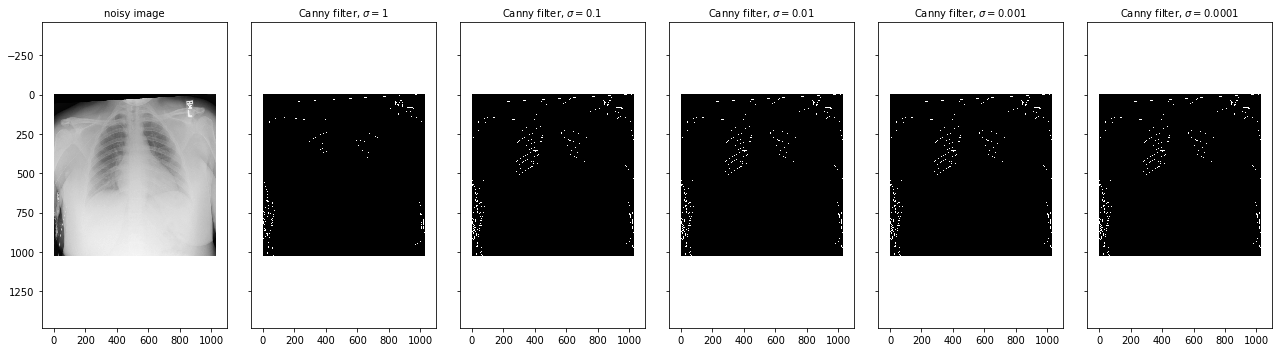

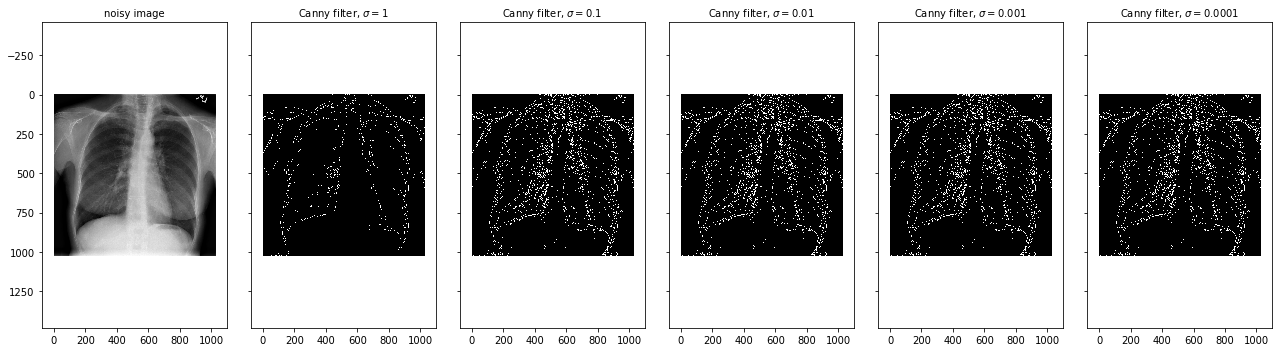

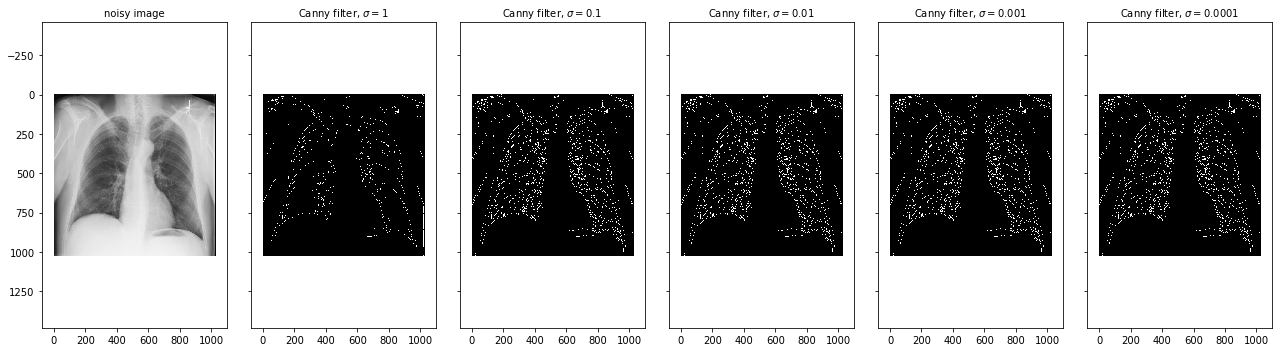

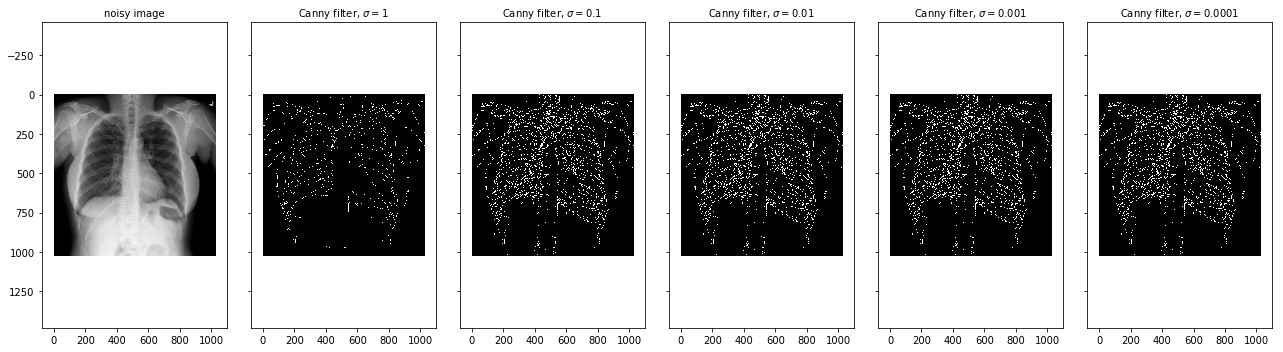

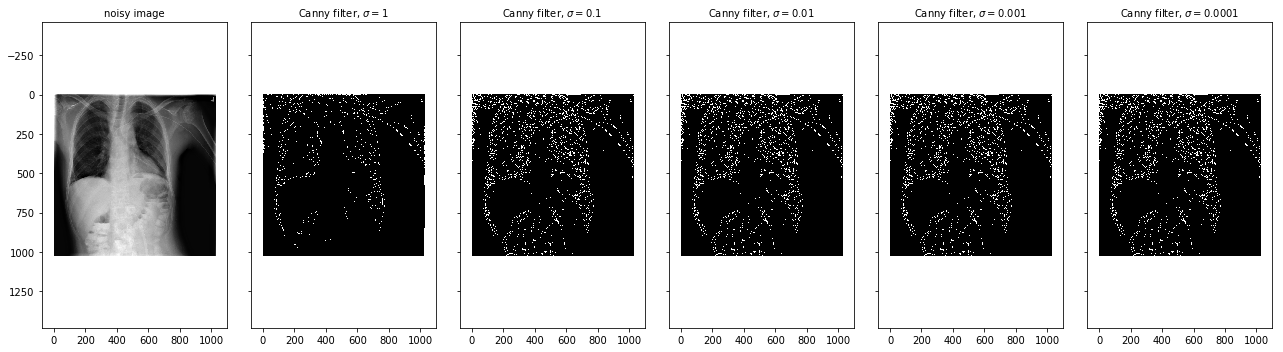

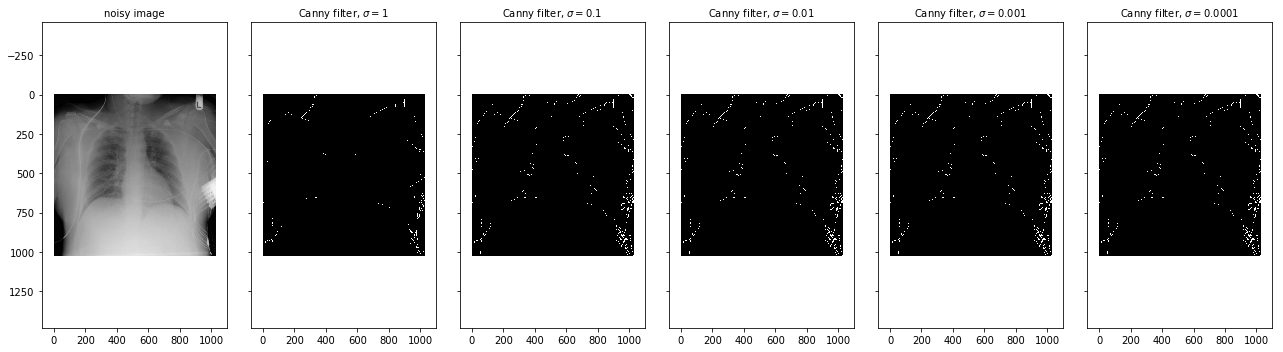

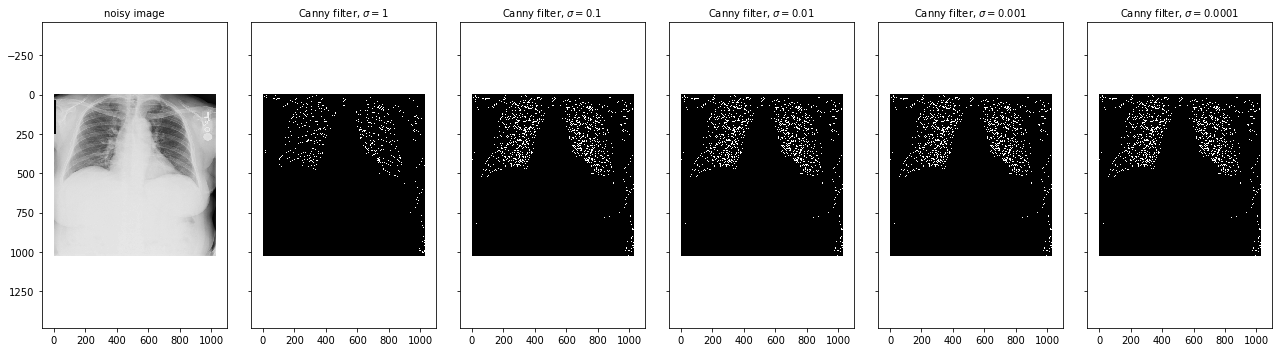

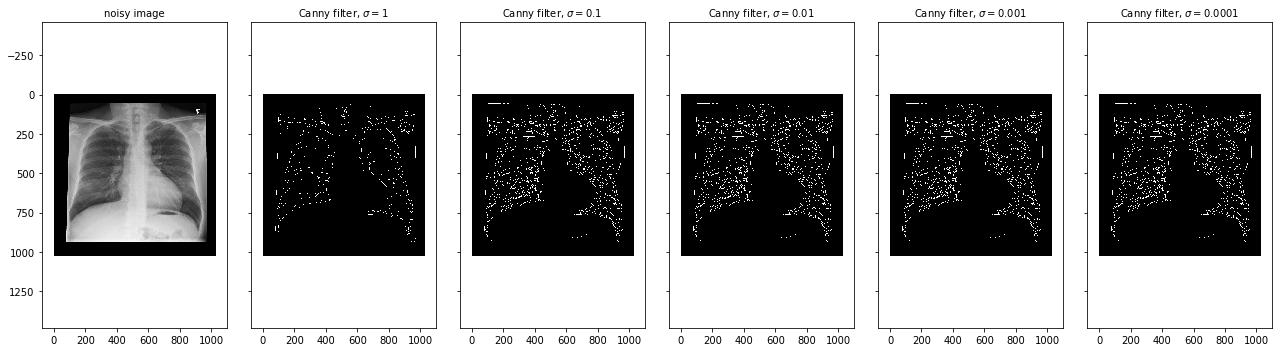

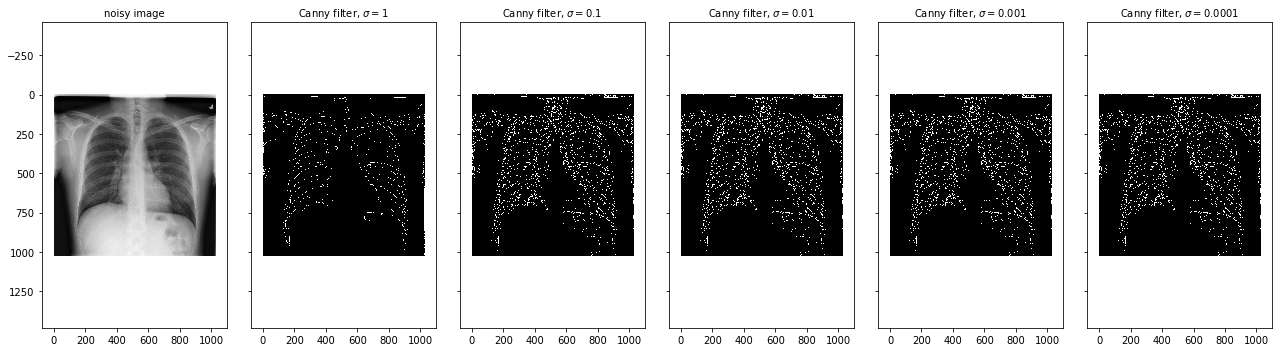

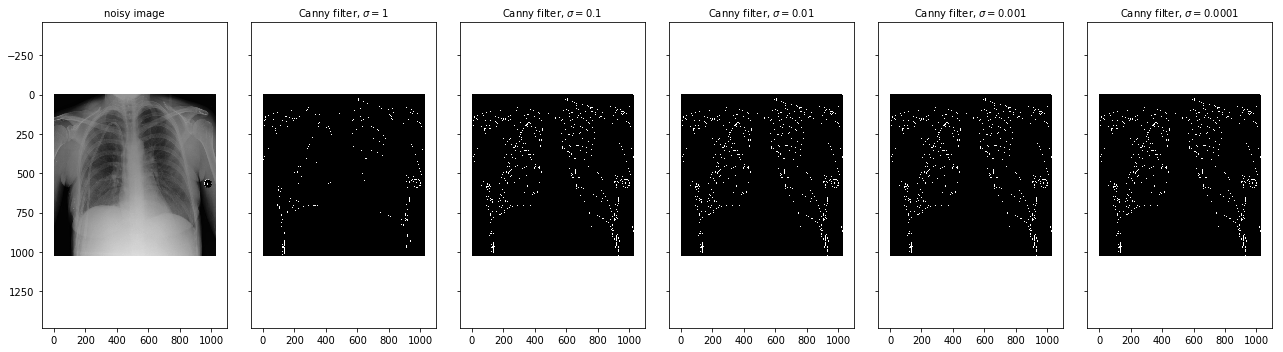

In [107]:
## detect edges for normal lungs
for p_id in normal_patient_ids.patientId:
    ds = pydicom.dcmread(train_images_dir + p_id + '.dcm')
    get_filtered_edges(ds.pixel_array)

<a id='model_fitting'></a>
## Model Fitting

<a id='creating_training_set'></a>
### Create a train/test split for the model validation

In [111]:
merged_df.head()

patientId      x      y  width  height  target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

              target_class_desc  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [267]:
merged_df.shape

(28989, 7)

In [268]:
## Export to csv for other calculations
merged_df.to_csv('./datasets/merged_data',sep='\t')

In [117]:
merged_df.groupby(['target','target_class_desc'])[['target']].count()

target
target target_class_desc                   
0      No Lung Opacity / Not Normal   11500
       Normal                          8525
1      Lung Opacity                    8964

###### In the following secotion, we will be creating train/test folder of normal and infected lungs which is one and easier way of implementing neural networks

In [120]:
## extract files with Normal and Lung Opacit

normal_lungs = merged_df['patientId'][merged_df.
                                      target_class_desc == 'Normal'].tolist()


In [121]:
normal_lungs

['003d8fa0-6bf1-40ed-b54c-ac657f8495c5',
 '009482dc-3db5-48d4-8580-5c89c4f01334',
 '009eb222-eabc-4150-8121-d5a6d06b8ebf',
 '00a85be6-6eb0-421d-8acf-ff2dc0007e8a',
 '00f87de5-5fe0-4921-93ea-914d7e683266',
 '01027bc3-dc40-4165-a6c3-d6be2cb7ca34',
 '017c7b5b-618e-4bc9-943c-04c6a988d992',
 '019ca122-9cdf-4704-b7a9-449c8a1c263e',
 '01a4059c-22f7-4f51-8a27-50aff0b3aeb3',
 '01aad2a6-3b93-45e3-bf37-2d73348cb6fc',
 '01b15f07-1149-4ff8-9756-bc821e41b97c',
 '01be3fe5-4a91-4c57-9af6-305966a7d0aa',
 '01c0b605-0a82-401b-9649-81252304ac45',
 '01cc7c75-4498-43ab-b650-5553d0507f76',
 '01e4fd43-4f2c-421f-bd68-c756dceb5742',
 '01ef1712-90a6-4946-ad86-fc76b0cf2d3b',
 '01f0d9cc-f69e-471a-987a-be73a36e18cc',
 '01f0f4bf-e678-430e-b43d-2968e2c4976c',
 '01f11e57-5c11-4ab0-9312-d88c3826721c',
 '01f4cd36-caa1-480f-9d8c-92e80cf7b197',
 '01fe92f7-ff87-4f9e-9077-e00e670d1b47',
 '020fb648-3b1e-404a-a0b4-f25d6b277c1a',
 '022b7bbd-963b-49ea-afd7-b6b7986da555',
 '0280a39c-4891-4a7b-8073-710c3f5577a3',
 '029216c8-ea0d-

In [130]:
len(normal_lungs)

8525

In [126]:
len(normal_lungs) * 0.8

6820.0

In [127]:
normal_lungs_train = normal_lungs[:6820]

In [131]:
normal_lungs_test = normal_lungs[6821:8525]

In [122]:
infected_lungs = merged_df['patientId'][merged_df.
                                      target_class_desc == 'Lung Opacity'].tolist()

In [123]:
infected_lungs

['00436515-870c-4b36-a041-de91049b9ab4',
 '00436515-870c-4b36-a041-de91049b9ab4',
 '00704310-78a8-4b38-8475-49f4573b2dbb',
 '00704310-78a8-4b38-8475-49f4573b2dbb',
 '00aecb01-a116-45a2-956c-08d2fa55433f',
 '00aecb01-a116-45a2-956c-08d2fa55433f',
 '00c0b293-48e7-4e16-ac76-9269ba535a62',
 '00c0b293-48e7-4e16-ac76-9269ba535a62',
 '00f08de1-517e-4652-a04f-d1dc9ee48593',
 '00f08de1-517e-4652-a04f-d1dc9ee48593',
 '0100515c-5204-4f31-98e0-f35e4b00004a',
 '010ccb9f-6d46-4380-af11-84f87397a1b8',
 '010ccb9f-6d46-4380-af11-84f87397a1b8',
 '012a5620-d082-4bb8-9b3b-e72d8938000c',
 '012a5620-d082-4bb8-9b3b-e72d8938000c',
 '0174c4bb-28f5-41e3-a13f-a396badc18bd',
 '0174c4bb-28f5-41e3-a13f-a396badc18bd',
 '019d950b-dd38-4cf3-a686-527a75728be6',
 '019d950b-dd38-4cf3-a686-527a75728be6',
 '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce',
 '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce',
 '01a7353d-25bb-4ff8-916b-f50dd541dccf',
 '01a7353d-25bb-4ff8-916b-f50dd541dccf',
 '01adfd2f-7bc7-4cef-ab68-a0992752b620',
 '01b9e362-4950-

In [ ]:
infected_lungs = merged_df['patientId'][merged_df.
                                      target_class_desc == 'Lung Opacity'].tolist()

In [132]:
len(infected_lungs)

8964

In [133]:
len(infected_lungs) * 0.8

7171.200000000001

In [188]:
len(infected_lungs_test + normal_lungs_test)

3496

In [134]:
infected_lungs_train = infected_lungs[:7171]

In [135]:
infected_lungs_test = infected_lungs[7172:8964]

In [136]:
## Separate files into different folders
import shutil, os

In [224]:
def transfer_files(files, folder_location):
    os.chdir('./datasets/png_converted_files/')
    for f in files:
        shutil.copy(f+'.png', folder_location)

In [244]:
cd ..

/Users/alinaUpreti/Desktop/DataScienceImmersiveGA/Capstone Project


In [229]:
## Create normal training/test set
transfer_files(normal_lungs_train, '../train_images/normal/')

In [233]:
transfer_files(normal_lungs_test, '../test_images/normal/')

In [238]:
## Create infected training/test set
transfer_files(infected_lungs_train, '../train_images/infected/')

In [242]:
transfer_files(infected_lungs_test, '../test_images/infected/')

In [190]:
## Separate the unused images
unused_images = merged_df['patientId'][merged_df.
                                      target_class_desc == 'No Lung Opacity / Not Normal'].tolist()

In [191]:
unused_images

['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd',
 '00322d4d-1c29-4943-afc9-b6754be640eb',
 '00569f44-917d-4c86-a842-81832af98c30',
 '006cec2e-6ce2-4549-bffa-eadfcd1e9970',
 '008c19e8-a820-403a-930a-bc74a4053664',
 '00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b',
 '011d6f51-b732-4d45-a84d-90477325ef2d',
 '014b7b58-f641-4477-8bbc-ae6f337745d6',
 '01538c3b-3de9-4fbb-95a8-732235821bbf',
 '016b1f90-bb9a-4d3a-9c38-74af5fffd5b5',
 '019e035e-2f82-4c66-a198-57422a27925f',
 '01a5594f-e5d4-4f7a-b79d-3f57559fe37b',
 '01b56434-4dd9-4994-bcc5-0b70a36e415a',
 '01c09fb1-a917-46ee-8d94-44f844a4eb85',
 '01c7cc7c-7004-441f-9049-77b7b444dd6b',
 '01cfa23b-cc98-43af-a61b-56915f90b7ef',
 '01d1f0be-5216-4af5-b2dc-a160c1c56122',
 '01d72346-4459-4eaa-8a19-d3c92121d17f',
 '01e16ddb-682d-4901-b56d-8686c4f9f976',
 '01e800d4-4d8d-4ef5-a40a-f37b923bb7ad',
 '01ee3bcb-d6a8-4586-b0a5-9647969da07d',
 '01ef449e-d493-4db2-9162-d83c69f90f40',
 '01f6bf01-9887-498c-ab11-1d10c6a22221',
 '02051597-8a40-

In [194]:
transfer_files(unused_images, '../unused_images/')

In [198]:
ls datasets/

ls: datasets/: No such file or directory


In [205]:
os.listdir('./datasets/stage_1_train_images')

['7be6b4de-afe9-43c0-a581-0f49608c8976.dcm',
 '2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm',
 'd8e66874-305e-4c80-9b75-5e764eb718ff.dcm',
 '22f2d3ec-f7ea-4778-850d-bb111590202f.dcm',
 'cdaa07d4-4234-4cd2-b9bf-abbf5aed1bb4.dcm',
 '46c4f908-9292-437f-af42-4031fca621f2.dcm',
 '79fa156c-c4f5-478d-a14d-80cc4db5cb8d.dcm',
 'e8a6ccf4-845e-4663-b561-008bdf13c7fd.dcm',
 '6a975635-1118-4c26-b613-43fd34ce8b16.dcm',
 'ebc9da35-fa1b-4cc4-b963-16731802af49.dcm',
 'ce30917f-c3bf-47fa-ab69-a1062f387f3a.dcm',
 '79cb4053-b062-4be9-8922-9585b170d8fc.dcm',
 '94a021aa-e34c-439f-b30d-0c5a1a0c8539.dcm',
 '60e598ff-ee2b-4fa8-9e1e-6562dd19b00c.dcm',
 'fa2d2cf7-acfc-4c2a-a231-9e60abcf5d66.dcm',
 'c3b14740-9eb7-4b20-a9ce-e404cce4b8c7.dcm',
 'e6722c12-2875-4795-b377-badc4514d224.dcm',
 '505e3473-fe7f-4c3e-8684-b7f9ecf1d052.dcm',
 'ac710523-7dfb-4d63-821c-34b2d6ef03d7.dcm',
 '3a483825-5dc2-4318-b0a6-7378f155df2c.dcm',
 'd7571c7c-0a9d-4e24-9488-6e42b6572b36.dcm',
 'af59f4a2-32d4-4888-ac7f-fc0bcc23abd2.dcm',
 '92c29872

In [250]:
unused_images[0:5]

['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd',
 '00322d4d-1c29-4943-afc9-b6754be640eb',
 '00569f44-917d-4c86-a842-81832af98c30',
 '006cec2e-6ce2-4549-bffa-eadfcd1e9970']

In [255]:
## Drop all the unnecessary files 
def drop_unnecessary_files():
    for filename in os.listdir('./datasets/png_converted_files/'):
        if filename[:-4] in unused_images:
            os.unlink('./datasets/png_converted_files/'+filename)
            #print(filename)

## Only use when we are using multiple copies of same data. 
## drop_unnecessary_files() 

<a id='convert_dicom_to_png'></a>
### Convert dicom images to PNG

In [212]:
ls

Capstone - RSNA Pneumonia Detection Challenge 3.ipynb
Tensorflow.ipynb
Untitled Folder/
Untitled.ipynb
datasets/


In [211]:
import cv2
import PIL # optional

In [219]:
## Function to convert dcm file to png or jpg
def convert_dicom_to_png():
    # make it True if you want in PNG format
    PNG = True
    # Specify the .dcm folder path
    folder_path = "./datasets/stage_1_train_images"
    # Specify the output jpg/png folder path
    png_folder_path = "./datasets/png_converted_files"
    images_path = os.listdir(folder_path)
    for n, image in enumerate(images_path):
        ds = pydicom.dcmread(os.path.join(folder_path, image))
        pixel_array_numpy = ds.pixel_array
        if PNG == False:
            image = image.replace('.dcm', '.jpg')
        else:
            image = image.replace('.dcm', '.png')
        cv2.imwrite(os.path.join(png_folder_path, image), pixel_array_numpy)
        if n % 10000 == 0:
            print('{} image converted'.format(n))

In [220]:
ls

Capstone - RSNA Pneumonia Detection Challenge 3.ipynb
Tensorflow.ipynb
Untitled Folder/
Untitled.ipynb
datasets/


In [221]:
convert_dicom_to_png()

0 image converted
10000 image converted
20000 image converted


<a id='fitting_cnn'></a>
### Fit a CNN

In [1]:
## Importing the Keras libraries and packages
from keras.models import Sequential ## CNN is sequential so not graph
from keras.layers import Conv2D ## Images are 2D convolutions
from keras.layers import MaxPooling2D ## Get max features for 2D image
from keras.layers import Flatten ## Convert all the features into 1D matrix
from keras.layers import Dense ## connect fully connected layer into ANN

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
## Initialize the CNN
classifier = Sequential()

In [3]:
## Step 1 - Convolution (filters)
classifier.add(Conv2D(32, (3, 3), input_shape = (64,64,3),
                            activation = 'relu'))

In [4]:
## Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [5]:
## Step 3 - Flattening
classifier.add(Flatten())

In [6]:
## Step 4 - Make fully connected layer
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [7]:
## Compiling the CNN
classifier.compile(optimizer='adam', loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

<a id='image_augmentation'></a>
### Visualizing Image Augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
ls ./datasets/train_images/

infected/ normal/


In [137]:
## Image Augmentation visualizations
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        rotation_range=45)

In [138]:
## Get Batches
batches = train_datagen.flow_from_directory(
    'datasets/test_images',
    target_size=(224,224), 
    class_mode='binary', 
    batch_size=32)

x_batch, y_batch = next(batches)

Found 11298 images belonging to 2 classes.


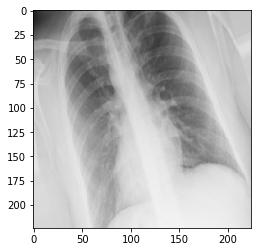

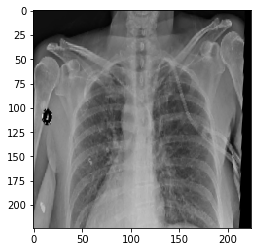

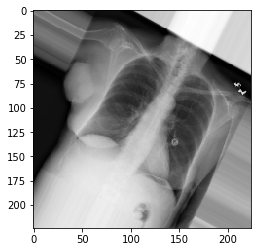

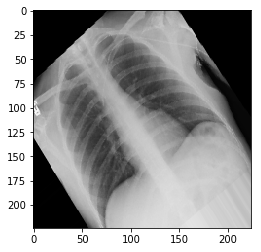

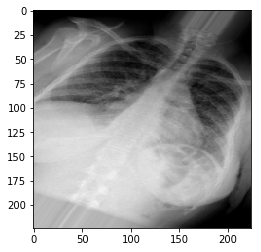

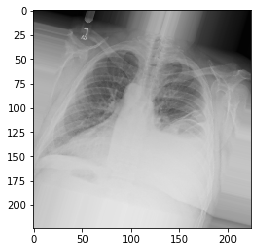

In [133]:
## Plot augmented images
for i in range (0,6):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()